In [1]:
### test_lgs_params.ipynb
### attempting to pull relevant parameters from science and weather data
### imports
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from astropy.io import fits
import lgs_metadata_compiler as md
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.axes_grid1 import make_axes_locatable
### My file
import ML_util as util
### ML algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
### Files and folders
root_dir = "/g/lu/data/gc/" # root data directory
tables = "/u/steverobinson/work/keckao/" # folder of data tables found in Steve's directory
meta_file = tables+"lgs_metadata2.fits" # test metadata table
# strehl and fwhm are labels, the rest are features
use_cols = ['strehl', 'fwhm', 'airmass', 'az', 'MASS', 'DIMM', 'wind_speed', 
               'wind_direction', 'temperature', 'relative_humidity', 'pressure']
Y_data = use_cols[:2]
# guessing that DIMM is the DIMM seeing, MASS is the MASS seeing
# not really sure what units anything is in

(5949, 47)
(3269, 11)


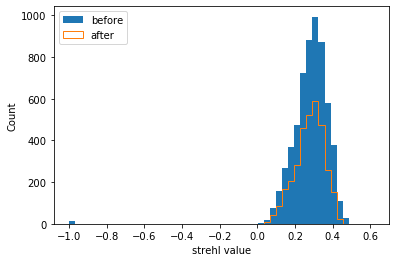

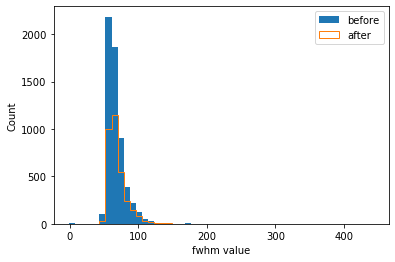

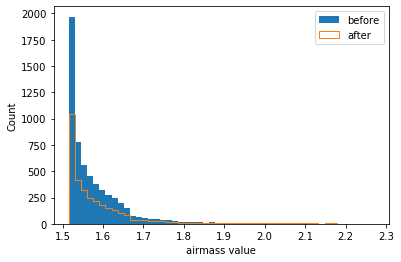

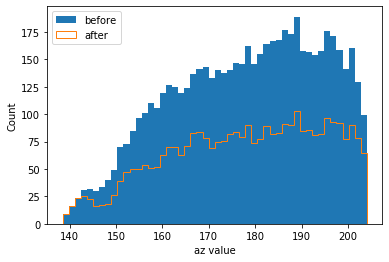

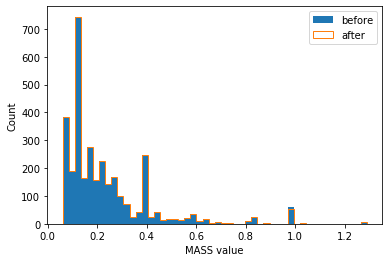

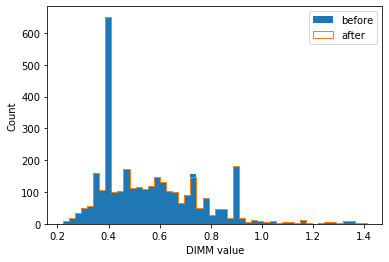

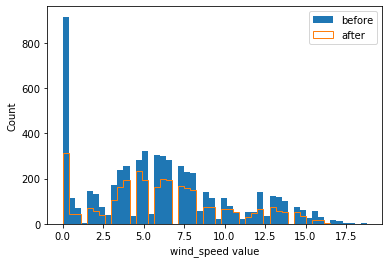

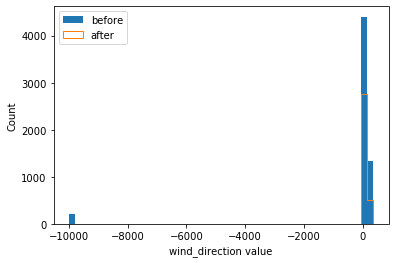

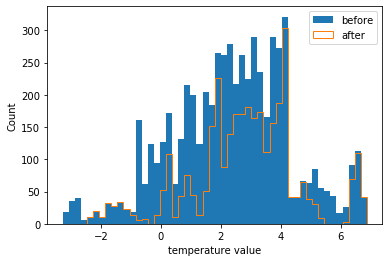

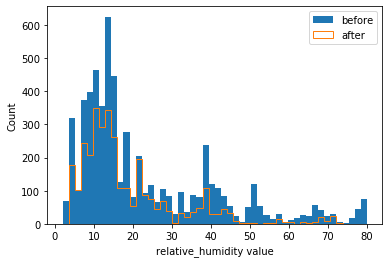

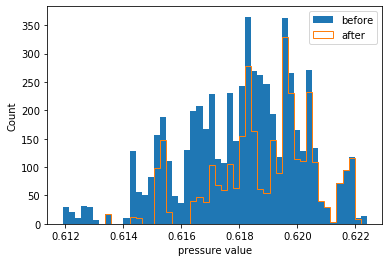

In [9]:
### Read info from Steve's metadata files
meta_data = Table.read(meta_file)
meta_data = meta_data.to_pandas() # convert to pandas
print(meta_data.shape)

# extract relevant data
meta_data = meta_data[use_cols]
# clean data
meta_clean = util.clean(meta_data)
print(meta_clean.shape)

### Graph the features to see what values they take on
bins = 50

for i, col in enumerate(use_cols):
    fig, ax = plt.subplots()
    '''
    # manually define bin edges for wind direction
    if col=="wind_direction":
        wd_filter = meta_data[col][meta_data[col] > -100]
        bin_edges = np.linspace(min(wd_filter), max(wd_filter), bins-1)
        bin_edges = np.insert(bin_edges, 0, [-10000, -9990])
        
        # Break axes
        divider = make_axes_locatable(ax[i])
        ax2 = divider.new_horizontal(size="300%", pad=0.2)
        fig.add_axes(ax2)
        
        # Plot data
        ax[i].hist(meta_data[col], bins=bin_edges) # outlier
        ax2.hist(meta_data[col], bins=bin_edges, label="before") # data
        
        # Clean up
        ax[i].set_xlim([-11000, -9900])
        ax[i].spines['right'].set_visible(False)
        ax[i].tick_params(right="off", labelright="off")
        ax2.set_xlim([0, 1000])
        ax2.tick_params(left="off", labelleft="off")
        ax2.spines['left'].set_visible(False)
        '''
        
        
    #else: # normal bin edges
    _, bin_edges, _ = ax.hist(meta_data[col], bins, label="before")
    
    # Clean histogram
    ax.hist(meta_clean[col], bins=bin_edges, histtype='step', label="after")
    
    ax.set_xlabel(col+" value")
    ax.set_ylabel("Count")
    ax.legend(loc='best')
    plt.savefig("plots/"+col+"_hist.png", bbox_inches="tight")  
    

#plt.tight_layout()
#plt.savefig("plots/feature_histograms.png")

In [4]:
# Extract y variables
Y = meta_clean[use_cols[:2]]
strehl = meta_clean['strehl']
fwhm = meta_clean['fwhm']

# Extract x variables
X = meta_clean[use_cols[2:]]

In [5]:
### Scale the data
# StandardScaler() subtracts the mean and divides by the standard deviation
# Very important for PCA to normalize for high-magnitude features
X_scaled = StandardScaler().fit_transform(X)
#X_scaled = X
# (1-tolerance) is the amount (%) of variation we keep in our data
tolerance = 0.01

In [6]:
### Basic PCA - extracts features which have the most variation in the data
pca = PCA(1-tolerance)
#pca = PCA(n_components=3)
pca.fit(X_scaled)
# View variance ratios
list(np.round(pca.explained_variance_ratio_, 2))
# 1. If the emphasis is on knowing what our features mean then this is not a great algorithm to use
# 2. We have so few features that we probably don't need to eliminate any if we use them as-is
# 3. The explained variance ratios are also all fairly small, so PCA isn't likely to help a lot

[0.25, 0.21, 0.17, 0.12, 0.08, 0.07, 0.05, 0.04, 0.01]

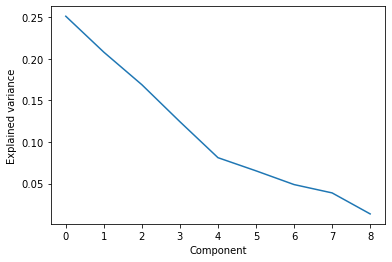

In [7]:
### Plot eigenvalues
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Explained variance")
plt.savefig("plots/pca_expl_var.png")

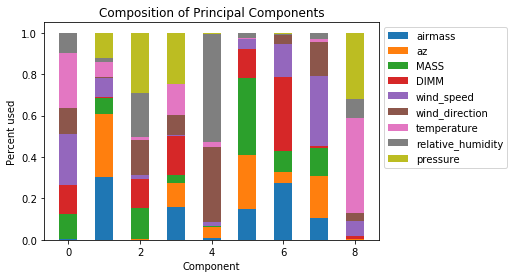

In [8]:
### Plot makeup of principal components
x = np.arange(0, pca.n_components_)
colors = plt.cm.get_cmap('viridis', pca.n_components_)

prev_bar = np.zeros(pca.n_components_)
for i, component in enumerate(pca.components_.T):
    c = component**2
    plt.bar(x, c, width=0.5, bottom=prev_bar, label=use_cols[2:][i])
    prev_bar += c

lgd = plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Component")
plt.ylabel("Percent used")
plt.title("Composition of Principal Components")
plt.savefig("plots/pca_composition.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
errors = {}
for col in Y.columns:
    y = Y[col]
    train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=123)
    errors[col] = test_y
    errors[col+"_X"] = test_X
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(train_X, train_y)
    train_pred = rf.predict(train_X)
    test_pred = rf.predict(test_X)
    
    # Calculate errors
    train_err = (train_pred-train_y)
    test_err = (test_pred-test_y)
    train_mape = np.abs(train_err)/train_y
    test_mape = np.abs(test_err)/test_y
    
    errors[col+"_mape_train"] = train_mape
    errors[col+"_mape_test"] = test_mape
    errors[col+"_err_train"] = train_err
    errors[col+"_err_test"] = test_err
    
    print(f"{col}:\ntraining total: {np.mean(np.abs(train_err))}, testing total: {np.mean(np.abs(test_err))}\ntraining %: {np.mean(train_mape)*100}, testing %: {np.mean(test_mape)*100}\n")

strehl:
training total: 0.010124369645042836, testing total: 0.02716228606356968
training %: 4.351639800489982, testing %: 11.357260340683082

fwhm:
training total: 1.8357321093431278, testing total: 4.964584352078239
training %: 2.3935812085391253, testing %: 6.834564195270462



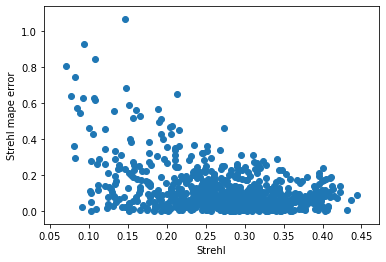

Text(0, 0.5, 'FWHM mape error')

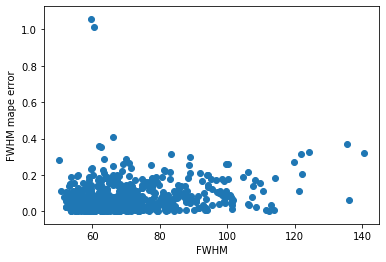

In [10]:
plt.scatter(errors["strehl"], np.abs(errors["strehl_mape_test"]))
plt.xlabel("Strehl")
plt.ylabel("Strehl mape error")
plt.show()
plt.scatter(errors["fwhm"], np.abs(errors["fwhm_mape_test"]))
plt.xlabel("FWHM")
plt.ylabel("FWHM mape error")

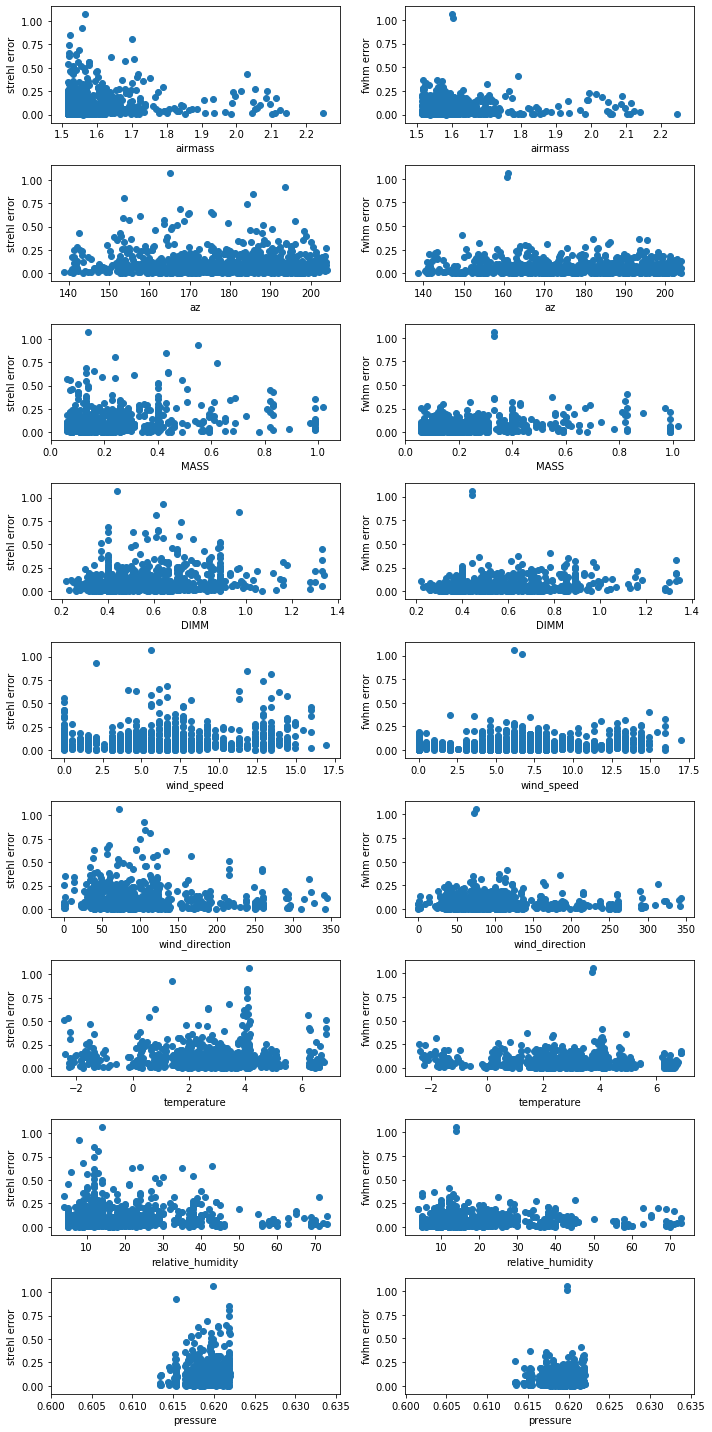

In [11]:
fig, ax = plt.subplots(len(errors["strehl_X"].columns),2, figsize=[10,20])
for i,col in enumerate(errors["strehl_X"].columns):
    ax[i,0].scatter(errors["strehl_X"][col], np.abs(errors["strehl_mape_test"]))
    ax[i,0].set_xlabel(col)
    ax[i,0].set_ylabel("strehl error")
    ax[i,1].scatter(errors["fwhm_X"][col], np.abs(errors["fwhm_mape_test"]))
    ax[i,1].set_xlabel(col)
    ax[i,1].set_ylabel("fwhm error")

plt.tight_layout()

In [ ]:
### Testing Random Forest Regressor
# This does not rely on feature scale, so we will leave it out
# This is basically identical to Kaggle's Intro ML exercise - just a proof of concept

# Set up parameters and data sets
percent_errors = {}

params = {"n_estimators":np.arange(5, 500, 10), "max_depth": np.arange(5, 100, 5), 
          "max_features":np.arange(1, len(X.columns)+1)}
for col in Y.columns:
    # train-test split
    y = Y[col]
    train_X, val_X, train_y, val_y = train_test_split(X, y)

    # Initialize Random Forest Regressor
    rf = RandomForestRegressor()
    search = GridSearchCV(rf, params, cv=5, scoring="neg_mean_absolute_error")
    best = search.fit(train_X, train_y)
    train_pred = best.predict(train_X)
    test_pred = best.predict(val_X)
    
    # Calculate errors
    train_err = (train_pred-train_y)/train_y
    test_err = (test_pred-val_y)/val_y
    train_mape = np.mean(np.abs(train_err))
    test_mape = np.mean(np.abs(test_err))
    
    percent_errors[col] = test_err

    print(col, "training error:", train_mape, "\nTest error:", test_mape)

In [2]:
### Plots
# Strehl
plt.hist(100*percent_errors['strehl'], bins=100)
plt.title("Strehl fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("plots/strehl_naive_rf_err.png")
plt.show()

# FWHM
plt.hist(100*percent_errors['fwhm'], bins=100)
plt.title("FWHM fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("plots/fwhm_naive_rf_err.png")
plt.show()

NameError: name 'plt' is not defined